# Final project: Stock predictions

## Load and scale ethereum dataset

In [88]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearning_2022/'
myDrive = '/content/drive/My Drive/DeepLearning_2022/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
coin_Bitcoin.csv  FinalProject_StockPredictions.ipynb  P2  P4
ETH-USD.csv	  P1				       P3  prices.csv


Text(0.5, 1.0, 'Ethereum historical price (scaled)')

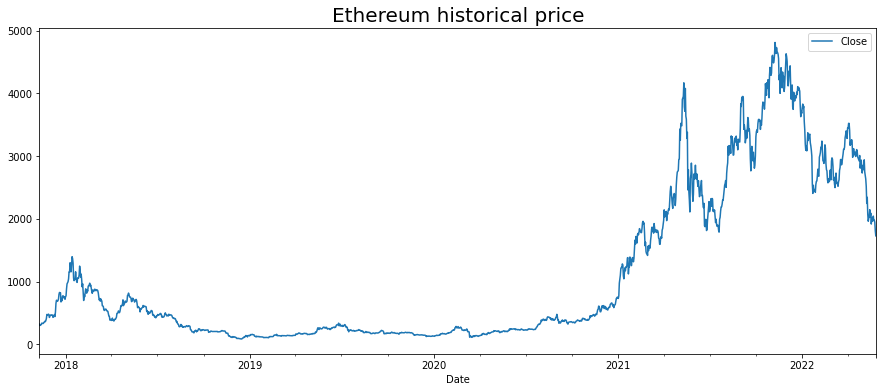

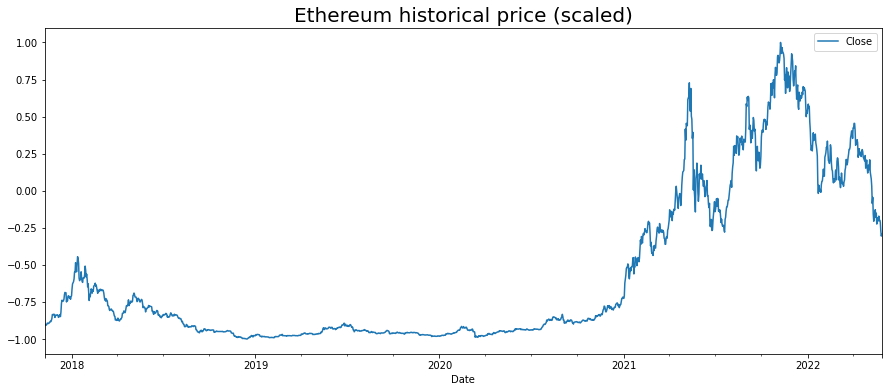

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/drive/MyDrive/DeepLearning_2022/ETH-USD.csv')


df=pd.read_csv('/content/drive/MyDrive/DeepLearning_2022/ETH-USD.csv', parse_dates=True, index_col=0)
df.drop(df.tail(4).index,inplace=True)
df=df.dropna(axis=0)
#df.info()


df[['Close']].plot(figsize=(15, 6))
plt.title('Ethereum historical price',fontsize=20)


scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df[['Close']].plot(figsize=(15, 6))
plt.title('Ethereum historical price (scaled)',fontsize=20)

## Function to divide into train and test

In [90]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


look_back = 30 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df[['Close']], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train=torch.from_numpy(x_train).float()
y_train=torch.from_numpy(y_train).float()
x_test=torch.from_numpy(x_test).float()
y_test=torch.from_numpy(y_test).float()



x_train.shape =  (1306, 29, 1)
y_train.shape =  (1306, 1)
x_test.shape =  (326, 29, 1)
y_test.shape =  (326, 1)


##LSTM model definition

In [91]:
hidden_dim = 20

class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 

        return out


lstm = LSTM_model(input_dim=1, hidden_dim=hidden_dim, num_layers=2,output_dim=1)
criterion = nn.MSELoss()

## Train LSTM with ethereum train dataset

In [92]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
optimizer_lstm = torch.optim.SGD(lstm.parameters(), lr=0.01)


for t in range(num_epochs):
    # Forward pass
    y_train_pred = lstm(x_train)
    loss = criterion(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer_lstm.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer_lstm.step()
  

Epoch  10 MSE:  0.517561674118042
Epoch  20 MSE:  0.3326132297515869
Epoch  30 MSE:  0.2253102958202362
Epoch  40 MSE:  0.16340279579162598
Epoch  50 MSE:  0.12800879776477814
Epoch  60 MSE:  0.10796405375003815
Epoch  70 MSE:  0.09670403599739075
Epoch  80 MSE:  0.0904143899679184
Epoch  90 MSE:  0.08690816164016724


## Test LSTM model ethereum

In [93]:
y_test_pred = lstm(x_test)

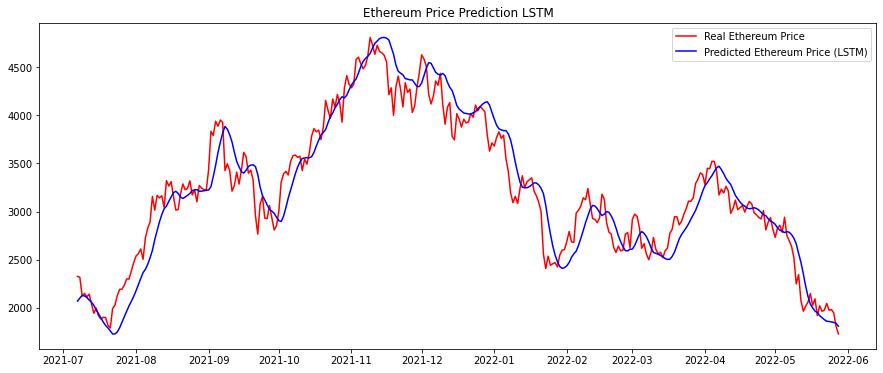

Loss =  0.009200421186564401


In [94]:
#plt.figure(figsize=(10,10))
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
y_test_trans=scaler.inverse_transform(y_test)
axes.plot(df[len(df)-len(y_test):].index, y_test_trans, color = 'red', label = 'Real Ethereum Price')

scaler2 = MinMaxScaler(feature_range=(min(y_test_trans), max(y_test_trans)))
y_test_pred = y_test_pred.detach().numpy()
y_test_pred = scaler2.fit_transform(y_test_pred)

axes.plot(df[len(df)-len(y_test_pred):].index, y_test_pred, color = 'blue', label = 'Predicted Ethereum Price (LSTM)')
plt.title('Ethereum Price Prediction LSTM')
plt.legend()
plt.show()


y_test_pred_scaled=scaler.transform(y_test_pred)
y_test_trans_scaled=scaler.transform(y_test_trans)
loss = criterion(torch.from_numpy(y_test_pred_scaled), torch.from_numpy(y_test_trans_scaled))
print('Loss = ',loss.item())


## Define RNN model

In [95]:
rnn = nn.RNN(input_size = 1,hidden_size = 1,bias = False, batch_first = True)
init_state = torch.zeros(1,1306,1) #seq_size, batch_size, feature_size 


optimizer = torch.optim.SGD(rnn.parameters(), lr=0.05)
criterion = nn.MSELoss()
l_rnn = []

## RNN training loop

In [96]:
number_or_epoch = 300
for iter in range(number_or_epoch):
    
    optimizer.zero_grad()
    
    #print('x shape',x.shape)
    yHatAll,_ = rnn(x_train,init_state)

    output = yHatAll[:,-1,:]#we just need last output

    loss = criterion(output,y_train)
    l_rnn.append(loss.item())
    loss.backward()
    optimizer.step()
    
    #print('loss : ',loss.item())
    #print(,'output : ',output,y)
    
#plt.plot(l_rnn,c='red')

## Test RNN model ethereum

In [97]:
y_test_pred_rnn,_ = rnn(x_test)
y_test_pred_rnn=y_test_pred_rnn[:,-1,:]
print(y_test_pred_rnn.shape)

torch.Size([326, 1])


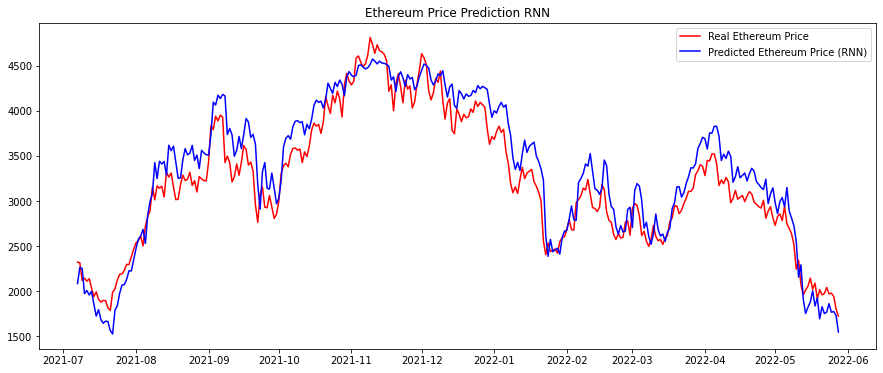

Loss =  0.0112155289309424


In [98]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test_trans, color = 'red', label = 'Real Ethereum Price')



y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

axes.plot(df[len(df)-len(y_test_pred_rnn):].index, y_test_pred_rnn, color = 'blue', label = 'Predicted Ethereum Price (RNN)')
plt.title('Ethereum Price Prediction RNN')
plt.legend()
plt.show()


y_test_pred_rnn_scaled=scaler.transform(y_test_pred_rnn)
loss = criterion(torch.from_numpy(y_test_pred_rnn_scaled), torch.from_numpy(y_test_trans_scaled))
print('Loss = ',loss.item())

## Bitcoin dataset (load and scale)

Text(0.5, 1.0, 'Bitcoin historical price (scaled)')

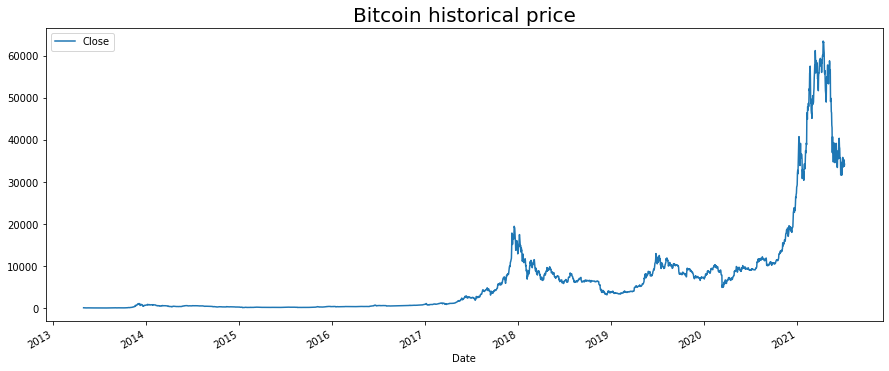

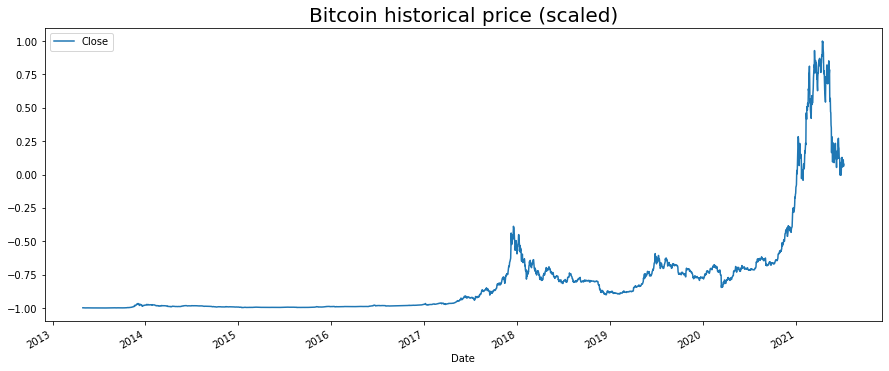

In [99]:

df_bit=pd.read_csv('/content/drive/MyDrive/DeepLearning_2022/coin_Bitcoin.csv', parse_dates=True, index_col=3)
df_bit[['Close']].plot(figsize=(15, 6))
plt.title('Bitcoin historical price',fontsize=20)


scaler = MinMaxScaler(feature_range=(-1, 1))
df_bit['Close'] = scaler.fit_transform(df_bit['Close'].values.reshape(-1,1))
df_bit[['Close']].plot(figsize=(15, 6))
plt.title('Bitcoin historical price (scaled)',fontsize=20)

## Bitcoin prepare data (all sequences are for testing)

In [100]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    
    test_set_size = int(np.round(0.99999*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [101]:
look_back = 30 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_bit[['Close']], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train=torch.from_numpy(x_train).float()
y_train=torch.from_numpy(y_train).float()

#All data is test
x_test=torch.from_numpy(x_test).float()
y_test=torch.from_numpy(y_test).float()

x_train.shape =  (0, 29, 1)
y_train.shape =  (0, 1)
x_test.shape =  (2961, 29, 1)
y_test.shape =  (2961, 1)


## Bitcoin test LSTM

In [102]:
y_test_pred = lstm(x_test)

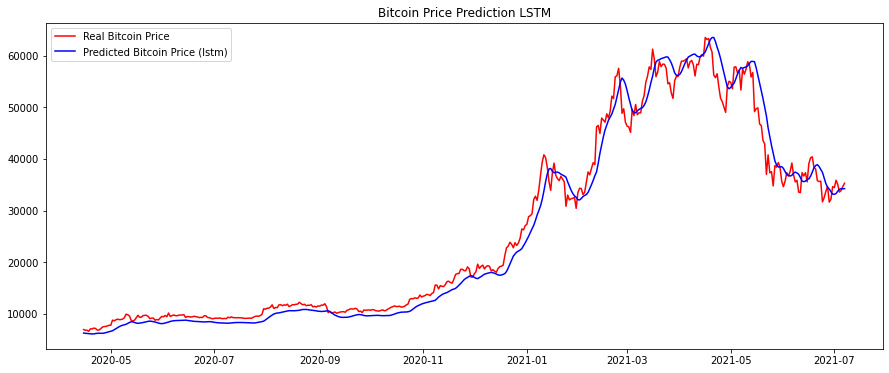

Loss =  0.0014130446009793763


In [103]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
y_test_trans=scaler.inverse_transform(y_test)
axes.plot(df_bit[len(df_bit)-len(y_test[-450:-1]):].index, y_test_trans[-450:-1], color = 'red', label = 'Real Bitcoin Price')

scaler2 = MinMaxScaler(feature_range=(min(y_test_trans), max(y_test_trans)))
y_test_pred = y_test_pred.detach().numpy()
y_test_pred = scaler2.fit_transform(y_test_pred)

axes.plot(df_bit[len(df_bit)-len(y_test_pred[-450:-1]):].index, y_test_pred[-450:-1], color = 'blue', label = 'Predicted Bitcoin Price (lstm)')
plt.title('Bitcoin Price Prediction LSTM')
plt.legend()
plt.show()

y_test_pred_scaled=scaler.transform(y_test_pred)
y_test_trans_scaled=scaler.transform(y_test_trans)
loss = criterion(torch.from_numpy(y_test_pred_scaled), torch.from_numpy(y_test_trans_scaled))
print('Loss = ',loss.item())

## Bitcoin test RNN

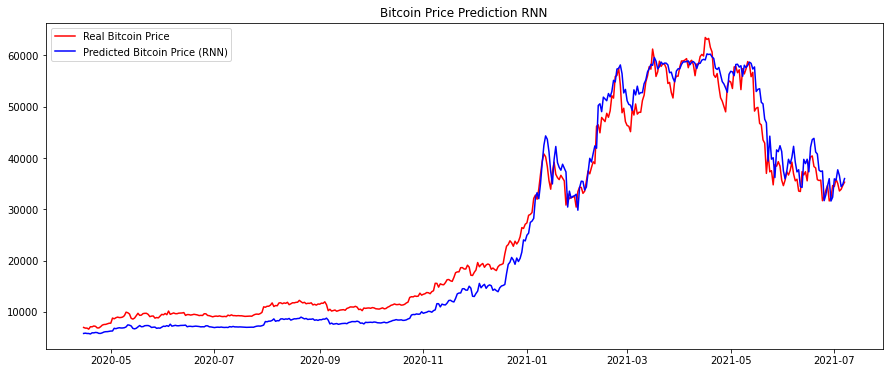

Loss =  0.006647864058897333


In [104]:
y_test_pred_rnn,_ = rnn(x_test)
y_test_pred_rnn=y_test_pred_rnn[:,-1,:]

figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_bit[len(df_bit)-len(y_test[-450:-1]):].index, y_test_trans[-450:-1], color = 'red', label = 'Real Bitcoin Price')

y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

axes.plot(df_bit[len(df_bit)-len(y_test_pred_rnn[-450:-1]):].index, y_test_pred_rnn[-450:-1], color = 'blue', label = 'Predicted Bitcoin Price (RNN)')
plt.title('Bitcoin Price Prediction RNN')
plt.legend()
plt.show()

y_test_pred_rnn_scaled=scaler.transform(y_test_pred_rnn)
loss = criterion(torch.from_numpy(y_test_pred_rnn_scaled), torch.from_numpy(y_test_trans_scaled))
print('Loss = ',loss.item())

# FORECASTS ethereum

In [105]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  1 of 1 completed


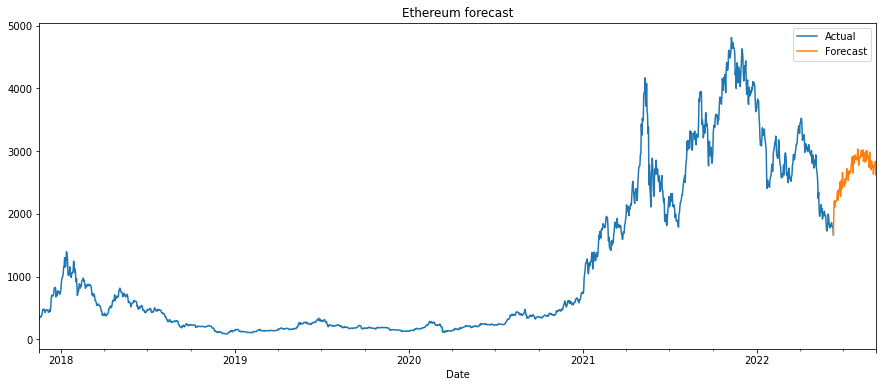

In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)


# download the data
df = yf.download(tickers='ETH-USD', start='2017-11-17',
                end='2022-06-10')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 30  # length of input sequences (lookback period)
n_forecast = 90  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=20, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='Ethereum forecast',figsize=(15,6))


In [85]:
print('x_train.shape = ',X.shape)
print('y_train.shape = ',Y.shape)

print('X_input.shape = ',X_.shape)
print('y_predicted.shape = ',Y_.shape)

x_train.shape =  (1548, 30, 1)
y_train.shape =  (1548, 90, 1)
X_input.shape =  (1, 30, 1)
y_predicted.shape =  (90, 1)


# FORECASTS bitcoin

In [86]:
# download the data
df = yf.download(tickers='BTC-USD', start='2013-04-29',
                end='2022-06-10')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 90  # length of input sequences (lookback period)
n_forecast = 90  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=20, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

[*********************100%***********************]  1 of 1 completed


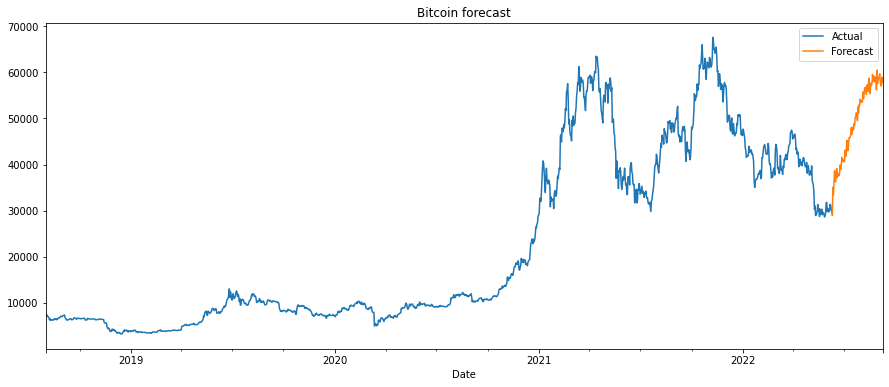

In [87]:
results = df_past.append(df_future).set_index('Date')
results=results.tail(1500)
# plot the results
results.plot(title='Bitcoin forecast',figsize=(15,6))